In the notebook, learned about:

    i. Visualization of trained model on Keras using Tensor Board 
    
    ii. Visualizing output of intermediate keras layers

In [48]:
import keras
from keras.datasets import mnist

from keras.models import Sequential
from keras.layers import *
#utilities help us transform our data later
from keras.utils import * 
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, TensorBoard
import os
import tensorflow as tf
from keras.models import load_model
from keras.models import Model
import cv2
%matplotlib inline

In [17]:

class TrainMnistDataSetDense:

    def __init__(self):

        self.image_height = 28
        self.image_width = 28
        self.image_depth = 1
    
    def preProcess(self, x_train, y_train, x_test, y_test):

        x_train = x_train.reshape(x_train.shape[0], 28*28)
        x_test = x_test.reshape(x_test.shape[0], 28*28)

        # Convert data type and normalise values

        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')


        x_train /= 255
        x_test /= 255 

        # Convert 1-dimensional class arrays to 10-dimensional class matrices

        y_train = np_utils.to_categorical(y_train,10)
        y_test = np_utils.to_categorical(y_test,10)

        return x_train, y_train, x_test, y_test
    
    
    def ModelDense(self, input_shape, num_classes):
        
        model = Sequential()
        model.add(Dense(512, input_shape=(input_shape,)))
        model.add(Activation('relu'))
        
        model.add(Dense(512))
        model.add(Activation('relu'))
        
        model.add(Dense(num_classes))
        model.add(Activation('softmax'))
        
        return model

 


In [18]:
class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()

# Model Dense

In [19]:

trainMnist = TrainMnistDataSetDense()
(x_train, y_train), (x_test, y_test) =  mnist.load_data()
X_train, Y_train, X_test, Y_test = trainMnist.preProcess(x_train, y_train, x_test, y_test)
input_shape = 28*28
# print "X traing ", 
# print "Y train ", Y_train.shape
num_classes = 10
nb_epoch = 1
batch_size = 32

# model = trainMnist.modelCNN(input_shape, num_classes)
model = trainMnist.ModelDense(X_train.shape[1], num_classes
                             )
model_save_path = 'TrainedModelMnist.hdf5'

model.compile(loss='categorical_crossentropy', optimizer='adadelta',metrics=['accuracy'])

print(model.summary())

csv_logger = CSVLogger('training.log')

early_stop = EarlyStopping('val_acc', patience=200, verbose=1)
model_checkpoint = ModelCheckpoint(model_save_path,
                                    'val_acc', verbose=0,
                                    save_best_only=True)

# tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
model_callbacks = [early_stop, model_checkpoint, csv_logger, TrainValTensorBoard(write_graph=True)]


# K.get_session().run(tf.global_variables_initializer())

model.fit(X_train,Y_train,batch_size,nb_epoch, verbose=1,validation_data=(X_test,Y_test),callbacks = model_callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
activation_4 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_5 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5130      
_________________________________________________________________
activation_6 (Activation)    (None, 10)                0         
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
None

In [20]:
result = model.evaluate(X_test, Y_test)
print "Loss ", result[0]
print "Accuracy ", result[1]

10000/10000 [==============================] - 1s 109us/step
Loss  0.09510410597138107
Accuracy  0.9721


# Model CNN

In [2]:

class TrainMnistDataSetCNN:

    def __init__(self):

        self.image_height = 28
        self.image_width = 28
        self.image_depth = 1
    
    def preProcessData(self, x_train, y_train, x_test, y_test):

        x_train = x_train.reshape(x_train.shape[0], self.image_height, self.image_width, self.image_depth)
        x_test = x_test.reshape(x_test.shape[0], self.image_height, self.image_width, self.image_depth)

        # Convert data type and normalise values

        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')


        x_train /= 255
        x_test /= 255 

        # Convert 1-dimensional class arrays to 10-dimensional class matrices

        y_train = np_utils.to_categorical(y_train,10)
        y_test = np_utils.to_categorical(y_test,10)

        return x_train, y_train, x_test, y_test
    

    def modelCNN(self, input_shape, number_of_classes):

        model = Sequential()

        model.add(Conv2D(64, (5, 5),  input_shape=(28,28,1)))
        model.add(PReLU())
        model.add(MaxPooling2D(pool_size=(3, 3)))
    
        #To connect the output of the 
        #pooling layer to the fully connected layer, we need to flatten this output into a single (N x 1) tensor.
        # Because dense layer always accepts array of vectors so flattening is necessary
        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(num_classes))
        model.add(Activation('softmax'))

        return model



# Notes: 

modelCNN always takes input shape in the form of (width, height, channels)


model.fit always take X_train and X_test shape as (n_images, width, height, channels)

Do not forget to flatten the output of convolution/pooling layer before applying dense layer

In [3]:

trainMnistCNN = TrainMnistDataSetCNN()
(x_train, y_train), (x_test, y_test) =  mnist.load_data()
X_train, Y_train, X_test, Y_test = trainMnistCNN.preProcessData(x_train, y_train, x_test, y_test)
input_shape = (28,28,1)
print "X traing ", X_train.shape 
print "Y train ", Y_train.shape
print Y_train[0]
print "X Test ", X_test.shape
print "Y Test ", Y_test.shape
num_classes = 10
nb_epoch = 1
batch_size = 64

model = trainMnistCNN.modelCNN(input_shape, num_classes)
# # model = trainMnist.ModelDense(X_train.shape[1], num_classes)
                             
model_save_path = 'TrainedModelMnist.hdf5'

model.compile(loss='categorical_crossentropy', optimizer='adadelta',metrics=['accuracy'])

print(model.summary())

csv_logger = CSVLogger('training.log')

early_stop = EarlyStopping('val_acc', patience=200, verbose=1)
model_checkpoint = ModelCheckpoint(model_save_path,
                                    'val_acc', verbose=0,
                                    save_best_only=True)

# # # tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

# # model_callbacks = [early_stop, model_checkpoint, csv_logger, TrainValTensorBoard(write_graph=True)]
model_callbacks = [early_stop, model_checkpoint, csv_logger]

# # # K.get_session().run(tf.global_variables_initializer())

model.fit(X_train,Y_train,batch_size,nb_epoch, verbose=1,validation_data=(X_test,Y_test),callbacks = model_callbacks)

X traing  (60000, 28, 28, 1)
Y train  (60000, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
X Test  (10000, 28, 28, 1)
Y Test  (10000, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 64)        1664      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 24, 24, 64)        36864     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               524416    
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_____________

In [ ]:
# Note: Flatten is necessary as it helps to connect output of pooling/convolution layer with Dense layer
# If you don't flatten it, network will give you output dimension error

## Predict from trained model

(28, 28, 1)
(10000, 28, 28, 1)


array([7])

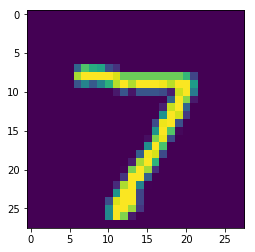

In [19]:
image1 = x_test[0]
plt.imshow(image1)
# model.predict()
# print (type(X_test[0]))
#reshape image to make it compatible with model 
i1 = X_test[0].reshape(1,28,28,1)
print (X_test[0].shape)
print (X_test.shape)
model.predict_classes(i1)

# get_3rd_layer_output = K.function([model.layers[0].input],
#                                   [model.layers[0].output])
# layer_output = get_3rd_layer_output([i1])[0]
# print (layer_output.shape)
# plt.imshow(layer_output)
# print model.layers[2].output

# Keras output of intermediate layers 

First we train the model and then plot the visualization of intermediate/first layer of keras

** Note: It is not necessary to train and visualize the output of layers. We can also determine the visualization before training the model

In [40]:
class newModelCNN: 
    
    
    def modelCNN(self, input_shape, number_of_classes):

        model = Sequential()

        model.add(Conv2D(3, (5, 5),  input_shape=(28,28,1)))
        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(num_classes))
        model.add(Activation('softmax'))

        return model
    
    
input_shape = (28,28,1)
# print "X traing ", X_train.shape 
# print "Y train ", Y_train.shape
# print Y_train[0]
# print "X Test ", X_test.shape
# print "Y Test ", Y_test.shape
num_classes = 10
nb_epoch = 1
batch_size = 64

cnn_n_model = newModelCNN()
n_model = cnn_n_model.modelCNN(input_shape, num_classes)


In [41]:
model_save_path = 'n_modelCnn.hdf5'

n_model.compile(loss='categorical_crossentropy', optimizer='adadelta',metrics=['accuracy'])

print(n_model.summary())

csv_logger = CSVLogger('training_n_model.log')

early_stop = EarlyStopping('val_acc', patience=200, verbose=1)
model_checkpoint = ModelCheckpoint(model_save_path,
                                    'val_acc', verbose=0,
                                    save_best_only=True)

# # # tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

# # model_callbacks = [early_stop, model_checkpoint, csv_logger, TrainValTensorBoard(write_graph=True)]
model_callbacks = [early_stop, model_checkpoint, csv_logger]

# # # K.get_session().run(tf.global_variables_initializer())

n_model.fit(X_train,Y_train,batch_size,nb_epoch, verbose=1,validation_data=(X_test,Y_test),callbacks = model_callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 24, 24, 3)         78        
_________________________________________________________________
flatten_3 (Flatten)          (None, 1728)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               221312    
_________________________________________________________________
activation_5 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
_________________________________________________________________
activation_6 (Activation)    (None, 10)                0         
Total para

test image shape  (28, 28, 1)
image after ex
('intermediate output shape ', (1, 24, 24, 3))
(24, 24, 3)


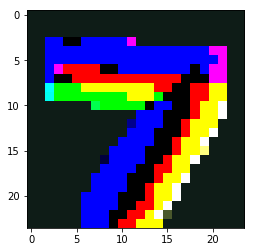

In [45]:
# take test image and convert to compatible size
new_im = x_test[0].reshape(28,28,1)
print "test image shape ", new_im.shape
image_predic = np.expand_dims(new_im, axis=0)
print "image after ex"
n_model.predict_classes(image_predic)

layer_name = 'conv2d_9'
intermediate_layer_model = Model(inputs=n_model.input,
                                 outputs=n_model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(image_predic)
print ("intermediate output shape ", intermediate_output.shape)

def visualize(image):
    
    image = np.squeeze(image, axis=0)
    print image.shape
    plt.imshow(image)
    
visualize(intermediate_output)


## Visualize output of intermediate layers without training



('image shape ', (183, 276, 3))


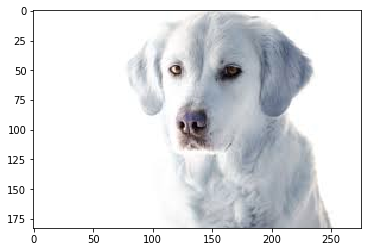

In [50]:
# load image 
dog = cv2.imread('./images/dog.jpeg')
print ("image shape ", dog.shape)
plt.imshow(dog)

In [71]:
demo_model = Sequential()
demo_model.add((Conv2D(3, (7, 7),  input_shape=dog.shape)))

# by default keras model expects images in batches, but we have single image 
dog_image = np.expand_dims(dog, axis=0) # add extra dimension
print ("dog image after expanding dimension ", dog_image.shape) # first element is batch 
print (demo_model.summary())


('dog image after expanding dimension ', (1, 183, 276, 3))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 177, 270, 3)       444       
Total params: 444
Trainable params: 444
Non-trainable params: 0
_________________________________________________________________
None


(177, 270, 3)


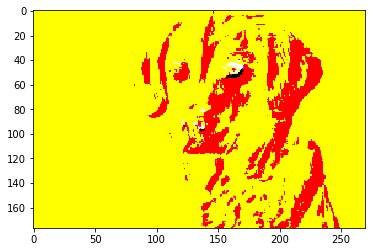

In [72]:
result = demo_model.predict(dog_image)

def visualize(image):
    
    image = np.squeeze(image, axis=0)
    print image.shape
    plt.imshow(image)
    
visualize(result)

This was the sample example, how to visualize output of intermediate layers. Similarly we can also add more layers and visualize the output